# 해외 축구 선수 이적료 예측 미션

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, KFold, train_test_split,learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

In [19]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')
submission = pd.read_csv('submission.csv')

In [34]:
print('train data ratio :',len(train)/(len(train)+len(test)))
print('test data ratio :',len(test)/(len(train)+len(test)))

train data ratio : 0.7
test data ratio : 0.3


---  
#### target data

In [34]:
target = train['value'] 
train.drop('value',axis=1,inplace=True)

---

---
#### 필요없는 변수 제거

In [21]:
train.drop(['id','name'],axis=1,inplace=True)
test.drop(['id','name'],axis=1,inplace=True)

---

In [22]:
contract_train = []
contract_test = []
for i in train['contract_until']:
    contract_train.append(i[-4:])
for i in test['contract_until']:
    contract_test.append(i[-4:])

train['contract_until'] = contract_train
test['contract_until'] = contract_test

train['contract_until'] = train['contract_until'].astype('int64')
test['contract_until'] = test['contract_until'].astype('int64')

In [13]:
train['contract_until'].value_counts()

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64

### age feature

남은계약기간(contract_until - 기준연도(여기서는 아마 17?18?)
나이에 관련된 파생변수(bin?)

In [23]:
# 계약 만료 연도 - 기준연도(2017)

# 현재 남은 계약 기간
train['contract'] = train['contract_until'] - 2017
test['contract'] = test['contract_until'] - 2017

In [24]:
train.drop('contract_until',axis=1,inplace=True)
test.drop('contract_until',axis=1,inplace=True)

나이를 10대후반,20대초,중,후반,30대초,중,후반,40대 (초 1 2 3, 중 4 5 6, 후 7 8 9)

In [25]:
train['age_cut'] = 0
test['age_cut'] = 0

In [55]:
train['age_cut'] = pd.cut(train['age'], bins=[0,19,23,26,29,33,36,39,43],
                          labels=['10','ealry20','mid20','late20','early30','mid30','rate30','40'])
test['age_cut'] = pd.cut(test['age'], bins=[0,19,23,26,29,33,36,39,43],
                          labels=['10','ealry20','mid20','late20','early30','mid30','rate30','40'])

---
---

---

---

### 예측 모델 및 성능 검증

#### 원핫인코딩
##### 상관관계 확인할 때 라벨인코딩을 먼저 진행


In [56]:
train_copy = train.copy()
test_copy = test.copy()

In [57]:
object_le = LabelEncoder()
train_copy[['continent','position','prefer_foot','age_cut']] = train_copy[['continent','position','prefer_foot','age_cut']].apply(object_le.fit_transform)

train_copy = pd.get_dummies(data= train_copy, columns=['continent'], prefix=['continent'])
train_copy = pd.get_dummies(data= train_copy, columns=['position'], prefix=['position'])
train_copy = pd.get_dummies(data= train_copy, columns=['prefer_foot'], prefix=['prefer_foot'])
train_copy = pd.get_dummies(data= train_copy, columns=['age_cut'], prefix=['age_cut'])

test_copy[['continent','position','prefer_foot','age_cut']] = test_copy[['continent','position','prefer_foot','age_cut']].apply(object_le.fit_transform)
test_copy = pd.get_dummies(data= test_copy, columns=['continent'], prefix=['continent'])
test_copy = pd.get_dummies(data= test_copy, columns=['position'], prefix=['position'])
test_copy = pd.get_dummies(data= test_copy, columns=['prefer_foot'], prefix=['prefer_foot'])
test_copy = pd.get_dummies(data= test_copy, columns=['age_cut'], prefix=['age_cut'])

scaler = RobustScaler()
train_copy[['stat_overall','stat_potential']] = scaler.fit_transform(train_copy[['stat_overall','stat_potential']])
test_copy[['stat_overall','stat_potential']] = scaler.transform(test_copy[['stat_overall','stat_potential']])

---

##### XGBoost target 자연로그

<AxesSubplot:>

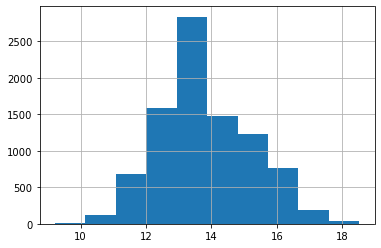

In [58]:
np.log1p(target).hist()

In [73]:
target = np.log1p(target)

In [75]:
xgb_model = xgb.XGBRegressor(random_state=42,use_label_encoder=False,eval_metric='logloss')
xgb_model.fit(train_copy,target)
target_pred = xgb_model.predict(train_copy)
y_pred = xgb_model.predict(test_copy)

# LinearRegression model의 학습 RMSE

# RMSE 저장
RMSE = mean_squared_error(np.expm1(np.log1p(target)),target_pred)**0.5
# score.append({'model':'XGBRegressor log',
#               'RMSE' : RMSE})
RMSE

0.045173333633687404

In [76]:
np.expm1(y_pred)

array([4.9545068e+07, 9.2110984e+07, 8.2234088e+07, ..., 5.8559551e+04,
       5.4239344e+04, 4.4986285e+04], dtype=float32)

In [43]:
# submission['value'] = np.expm1(y_pred)
# submission.to_csv('log.csv',index=False)

# learning curve

Training scores:

 [[-6.27919582e-12 -2.42460855e-11 -2.42460855e-11 -2.42460855e-11
  -2.42460855e-11]
 [-2.58259998e-06 -3.70515600e-06 -3.70515600e-06 -3.70515600e-06
  -3.70515600e-06]
 [-2.32700956e-04 -5.54125778e-05 -5.54125778e-05 -5.54125778e-05
  -5.54125778e-05]
 [-1.17931481e-03 -1.10867873e-03 -1.06947202e-03 -1.06947202e-03
  -1.06947202e-03]
 [-1.62260754e-03 -1.59949213e-03 -1.82792098e-03 -1.87083301e-03
  -1.87083301e-03]
 [-1.76844201e-03 -1.86235709e-03 -1.92539822e-03 -1.87342102e-03
  -2.00519915e-03]]

 ----------------------------------------------------------------------

Validation scores:

 [[-1.42759658e+00 -1.72366886e+01 -2.49502105e+01 -3.00603080e+01
  -4.15442734e+01]
 [-7.16400053e-01 -6.65746708e+00 -1.18350532e+01 -1.56338663e+01
  -2.44732637e+01]
 [-7.13095824e-01 -2.62214091e+00 -6.03799851e+00 -8.84271811e+00
  -1.58051162e+01]
 [-7.32986370e-01 -1.05469481e-01 -1.65961374e+00 -3.23203022e+00
  -7.78987464e+00]
 [-7.35174371e-01 -1.13897705e-01 -

(0.0, 24.0)

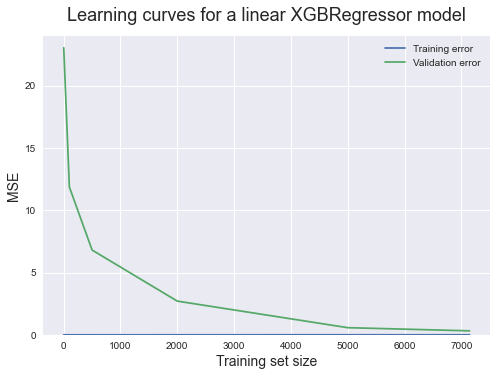

In [144]:
train_sizes = [1,100, 500, 2000, 5000, 7145]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = xgb.XGBRegressor(),
X = train_copy[train_copy.columns],
y = target, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear XGBRegressor model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,24)

---
하이퍼 파라미터

Training scores:

 [[-3.65635759e-04 -9.64009257e-05 -9.64009257e-05 -9.64009257e-05
  -9.64009257e-05]
 [-1.46727768e-03 -1.03269702e-03 -1.03269702e-03 -1.03269702e-03
  -1.03269702e-03]
 [-2.53108853e-03 -2.58411207e-03 -2.54880237e-03 -2.54880237e-03
  -2.54880237e-03]
 [-2.76849663e-03 -2.98287683e-03 -3.15483191e-03 -3.18315014e-03
  -3.18315014e-03]
 [-3.03325809e-03 -3.14110367e-03 -3.16873803e-03 -3.32644668e-03
  -3.13534476e-03]]

 ----------------------------------------------------------------------

Validation scores:

 [[-7.53337924e-01 -6.48906034e+00 -1.15293526e+01 -1.51886986e+01
  -2.36587716e+01]
 [-6.69757553e-01 -2.58356649e+00 -6.01946024e+00 -8.87586845e+00
  -1.58107558e+01]
 [-6.34199282e-01 -8.71704646e-02 -1.64890732e+00 -3.21750703e+00
  -7.78069125e+00]
 [-6.24785662e-01 -1.04307532e-01 -1.16916297e-02 -1.62884273e-01
  -1.95294132e+00]
 [-6.01670901e-01 -1.11330040e-01 -9.68307660e-03 -2.82756387e-02
  -7.16850311e-01]]
Mean training scores

 100     0.0

(0.0, 12.0)

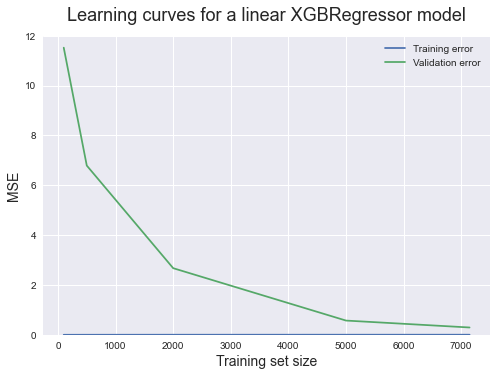

In [143]:
train_sizes = [100, 500, 2000, 5000, 7145]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = xgb.XGBRegressor(learning_rate = 0.1,
                             n_estimators=1000,
                             max_depth=3,
                             min_child_weight=5,
                             gamma=0,
                             # reg_alpah=1e-05,
                             subsample=0.71,
                             colsample_bytree=0.6,
                             # objective='reg:linear',
                             nthread=-1,
                             scale_pos_weight=1,
                             seed=42),
X = train_copy[train_copy.columns],
y = target, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear XGBRegressor model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,12)

---

---
* 하이퍼파라미터 조정